# Time Series Prediction with Convolutional Neural Networks ($CNN$)

AUTHOR: Anurag Dutta (anuragdutta.research@gmail.com)

SUPERVISOR: Tanujit Chakraborty (tanujit.chakraborty@sorbonne.ae)

CREATED: 2023-03-06 21:41:12

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Gathering Dependencies

_Importing Required Libraries_

In [ ]:
pip install hampel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from numpy import array

## Loading Datasets

_KYOTO DST_

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/new/datasets/dst.csv")
training_set = data.iloc[:, 1]
print(training_set)

0         -7
1        -10
2        -10
3         -6
4         -2
          ..
139867   -16
139868   -14
139869   -14
139870   -15
139871   -14
Name: dst, Length: 139872, dtype: int64


## Preprocessing the Data

In [ ]:
# univariate data preparation
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(training_set, n_steps)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

Streaming output truncated to the last 5000 lines.
[-10  -7  -4] -4
[-7 -4 -4] -7
[-4 -4 -7] -12
[ -4  -7 -12] -18
[ -7 -12 -18] -17
[-12 -18 -17] -17
[-18 -17 -17] -16
[-17 -17 -16] -12
[-17 -16 -12] -14
[-16 -12 -14] -18
[-12 -14 -18] -23
[-14 -18 -23] -24
[-18 -23 -24] -22
[-23 -24 -22] -19
[-24 -22 -19] -16
[-22 -19 -16] -16
[-19 -16 -16] -18
[-16 -16 -18] -18
[-16 -18 -18] -18
[-18 -18 -18] -18
[-18 -18 -18] -17
[-18 -18 -17] -14
[-18 -17 -14] -15
[-17 -14 -15] -16
[-14 -15 -16] -13
[-15 -16 -13] -12
[-16 -13 -12] -13
[-13 -12 -13] -15
[-12 -13 -15] -13
[-13 -15 -13] -13
[-15 -13 -13] -12
[-13 -13 -12] -11
[-13 -12 -11] -6
[-12 -11  -6] -7
[-11  -6  -7] -10
[ -6  -7 -10] -14
[ -7 -10 -14] -15
[-10 -14 -15] -14
[-14 -15 -14] -12
[-15 -14 -12] -11
[-14 -12 -11] -9
[-12 -11  -9] -7
[-11  -9  -7] -6
[-9 -7 -6] -6
[-7 -6 -6] -5
[-6 -6 -5] -3
[-6 -5 -3] -1
[-5 -3 -1] 0
[-3 -1  0] -1
[-1  0 -1] -4
[ 0 -1 -4] -5
[-1 -4 -5] -7
[-4 -5 -7] -8
[-5 -7 -8] -7
[-7 -8 -7] -5
[-8 -7 -5] -6
[-7 -5 

## Train and Test Split

In [ ]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size
dataX = np.array(X)
dataY = np.array(y)
trainX = np.array(X[0:train_size])
trainY = np.array(y[0:train_size])
testX = np.array(X[train_size:len(X)])
testY = np.array(y[train_size:len(y)])
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(111895, 1, 3) (111895,) (27974, 1, 3) (27974,)


## Model ($CNN$)

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
n_steps = 3
# split into samples
X, y = split_sequence(training_set, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
# model = Sequential()
# model.add(LSTM(50, activation='relu', input_shape=(3, n_features)))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')

model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(trainX, trainY, epochs=500, batch_size=64, validation_data=(testX, testY), verbose=1, shuffle=False)

# # fit model
# history = model.fit(X, y,epochs=50)

Epoch 1/500
1749/1749 [==============================] - 12s 5ms/step - loss: 68.1278 - val_loss: 24.9573
Epoch 2/500
1749/1749 [==============================] - 6s 3ms/step - loss: 59.3446 - val_loss: 24.8620
Epoch 3/500
1749/1749 [==============================] - 7s 4ms/step - loss: 59.7574 - val_loss: 24.7467
Epoch 4/500
1749/1749 [==============================] - 6s 3ms/step - loss: 58.5515 - val_loss: 24.6816
Epoch 5/500
1749/1749 [==============================] - 7s 4ms/step - loss: 58.4231 - val_loss: 24.6272
Epoch 6/500
1749/1749 [==============================] - 6s 3ms/step - loss: 58.3064 - val_loss: 24.6094
Epoch 7/500
1749/1749 [==============================] - 6s 4ms/step - loss: 58.2356 - val_loss: 24.5880
Epoch 8/500
1749/1749 [==============================] - 6s 3ms/step - loss: 58.1397 - val_loss: 24.5815
Epoch 9/500
1749/1749 [==============================] - 7s 4ms/step - loss: 57.9721 - val_loss: 24.5305
Epoch 10/500
1749/1749 [==============================

## Metrics ($CNN$)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
yhat = model.predict(testX, verbose=0)
rmse = np.sqrt(mean_squared_error(testY, yhat))
mae = np.sqrt(mean_absolute_error(testY, yhat))
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

Test RMSE: 4.909
Test MAE: 1.866


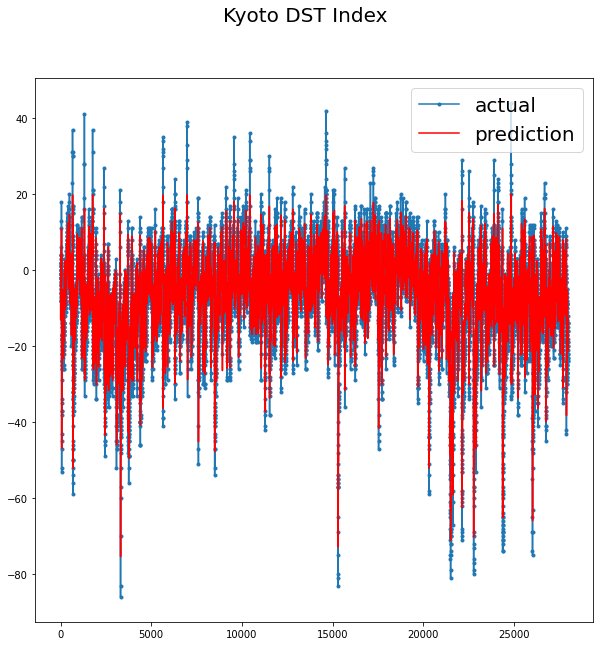

In [ ]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
anurag=[x for x in range(27974)]
plt.plot(anurag, testY[:27974], marker='.', label="actual")
plt.plot(anurag, yhat[:27974], 'r', label="prediction")
plt.suptitle('Kyoto DST Index', fontsize=20)
plt.legend(fontsize=20)
plt.show()